In [61]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import Video
from matplotlib.animation import FFMpegWriter

In [62]:
# Parameters
num_boids = 600
width = 350
height = 350
depth = 350
max_speed = 3.7
perception_radius = 25
edge_distance = 30
edge_repulsion = 20

In [63]:
# Boid class

class Boid:
    
    def __init__(self, x, y, z):

        self.position = np.array([x, y, z])
        self.velocity = np.random.randn(3)
        self.velocity = (self.velocity / np.linalg.norm(self.velocity)) * max_speed
        self.acceleration = np.zeros(3)

    def edges(self): # Compute repulsion force away from edges based on boid position

        force = np.zeros(3)

        for i, (pos, bound) in enumerate(zip(self.position, [width, height, depth])):
            if pos < edge_distance:
                force[i] += edge_repulsion / (pos + 1e-6) 
            elif pos > bound - edge_distance:
                force[i] -= edge_repulsion / (bound - pos + 1e-6)
        
        return force

    def accelerate(self, force): # General function to edit boid acceleration
        
        self.acceleration += force

    def update(self):

        # Compute edge repulsion and update velocity
        repulsion = self.edges()
        self.accelerate(repulsion)
        self.velocity += self.acceleration

        # Keep velocity within range
        speed = np.linalg.norm(self.velocity)
        if speed > max_speed:
            self.velocity = (self.velocity / speed) * max_speed
        
        #Make sure boid does not leave the space
        self.position = np.clip(self.position, [0, 0, 0], [width, height, depth])

        # Update position and reset acceleration
        self.position += self.velocity
        self.acceleration = np.zeros(3)

In [64]:
# Flock class

class Flock:
    
    def __init__(self, num_boids):

        self.boids = [Boid(np.random.rand() * width, np.random.rand() * height, np.random.rand() * depth) for _ in range(num_boids)]

    def apply_rules(self):

        for boid in self.boids: # Loop through every boid
            # Generate the 3 parameters
            separation = np.zeros(3)
            alignment = np.zeros(3)
            cohesion = np.zeros(3)
            total = 0

            for other in self.boids: # Compare the boid to every other boid
                distance = np.linalg.norm(boid.position - other.position)

                # Compute parameters if the other boid is within perception range of the present boid
                if boid != other and distance < perception_radius:
                    
                    diff = boid.position - other.position
                    diff /= distance
                    separation += diff # Separation makes sure the distance between boids is mantained

                    alignment += other.velocity # Alignment updates the boid's velocity in agreement to the one of its neighbors

                    cohesion += other.position # Cohesion moves the boid towards the average position of its neighbors

                    total += 1

            if total > 0:
                # Average the parameters obtained by the neighbors
                separation /= total 
                alignment /= total
                cohesion /= total
                cohesion -= boid.position # Subtract the boid position to compute the acceleration necessary to steer the boid towards the average position of its neighbors

            # Apply rules (and assign different weigths)
            boid.accelerate(separation * 4.3)
            boid.accelerate(alignment * 1.5)
            boid.accelerate(cohesion * 0.078)

    def update(self): # Update the velocity and position of the boids according ot the computed acceleration

        self.apply_rules()
        for boid in self.boids:
            boid.update()

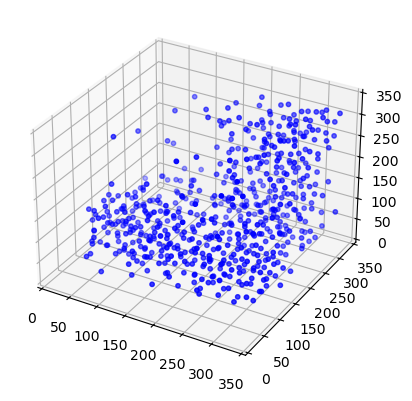

In [65]:
# Plot the simulation

flock = Flock(num_boids) # Generate the flock
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
positions = np.array([boid.position for boid in flock.boids])
sc_boids = ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=10, c='b') # Display all the boids
ax.set_xlim(0, width)
ax.set_ylim(0, height)
ax.set_zlim(0, depth)

def draw_boids(frame): # Function for FuncAnimation

    flock.update()
    positions = np.array([boid.position for boid in flock.boids])
    sc_boids._offsets3d = (positions[:, 0], positions[:, 1], positions[:, 2])
    return sc_boids

plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'
ani = FuncAnimation(fig, draw_boids, frames = 700, interval = 15)

# Save and display video
writer = FFMpegWriter(fps = 30, metadata = dict(artist = 'Me'), bitrate = 1800)
ani.save('boids_animation.mp4', writer = writer)
Video('boids_animation.mp4')